In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [2]:
import os
data = {}
a=0
max_len = 0
for j in range(1,4):
    for i in os.listdir('./final_dataset/train/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('./final_dataset/train/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')
            if len(data['%s'%a])/20>max_len:
                max_len=int(len(data['%s'%a])/20)

In [9]:
a = 0
inputs = np.zeros([10,len(data),4*max_len])
gt = np.zeros([11,len(data),4])
in_coord = np.zeros([10,len(data),2])
gt_coord = np.zeros([11,len(data),2])

for i in data:
    len_d = np.int(len(data['%s'%i])/20)
    inputs[:,a,:4] = data['%s'%i].loc[0:9,'x':'Vy']
    for m in range(10):
        frame = np.array(data['%s'%i].loc[m,'frameNb'])  
        for j in range(1,len_d):
            for k in range(10):
                if data['%s'%i].loc[j*20+k,'frameNb']==frame:
                    inputs[m,a,j*4:(j+1)*4]=data['%s'%i].loc[j*20+k,'x':'Vy']
    
    gt[:,a,:] = np.array(data['%s'%i].loc[9:19,['x','y','Vx','Vy']])
    in_coord[:,a,:] = np.array(data['%s'%i].loc[0:9,['x','y']])
    gt_coord[:,a,:] = np.array(data['%s'%i].loc[9:19,['x','y']])
    a +=1


inputs = torch.from_numpy(inputs).float()
gt = torch.from_numpy(gt).float()
inputs = inputs.permute([1,0,2])
gt = gt.permute([1,0,2])


In [10]:
inputs.shape, gt.shape

(torch.Size([5157, 10, 272]), torch.Size([5157, 11, 4]))

In [12]:
from torch import optim

lr = 0.01
lstm = LSTM(4*max_len,4)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

In [13]:
traindataset = utils.TensorDataset(inputs, gt[:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=2, shuffle=True)

epochs = 30
steps = 0
print_every = 200
running_loss = 0 #### DOD

for e in range(epochs):
    start = time.time()
    if (e+1)%5==0:
        lr /= 5
        optimizer = optim.SGD(lstm.parameters(), lr=0.005)

    for train_coord, ground_tru in iter(trainloader):
        steps += 1
        
        train_coord = train_coord.permute([1,0,2])
        ground_tru = ground_tru.permute([1,0,2])

        in_train = Variable(train_coord)
        targets = Variable(ground_tru)
        optimizer.zero_grad()
        #print(in_train.shape)
        #print(targets.shape)
        #pdb.set_trace()
        out = lstm.forward(in_train)
        out_bis = out[:,:,0:2].clone()
        #print(out_bis.shape)    
        for i in range(10):
            if i == 0:
                out_bis[i, :, 0:2] = in_train[-1, :, 0:2] + out[i, :, 2:]*0.4
            else:
                out_bis[i, :, 0:2] = out[i - 1, :, 0:2] + out[i, :, 2:]*0.4
        #print(out.shape)
        loss = criterion(out, targets) + criterion(out_bis, targets[:,:,0:2])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]

    
        if steps % print_every == 0:
                stop = time.time()
                print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch".format((stop - start)/print_every),
                  "{:.8f} lr".format(lr)
                 )
                running_loss = 0
                start = time.time()

/Users/rodolphefarrando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/30.. Loss: 5.4519.. 0.0031 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 3.2687.. 0.0044 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.4995.. 0.0028 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.5094.. 0.0056 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.0859.. 0.0028 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.2214.. 0.0031 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.1906.. 0.0037 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.0567.. 0.0035 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.1859.. 0.0043 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.0164.. 0.0056 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 1.9224.. 0.0030 s/batch 0.01000000 lr
Epoch: 1/30.. Loss: 2.1614.. 0.0033 s/batch 0.01000000 lr
Epoch: 2/30.. Loss: 1.9548.. 0.0004 s/batch 0.01000000 lr
Epoch: 2/30.. Loss: 1.8312.. 0.0039 s/batch 0.01000000 lr
Epoch: 2/30.. Loss: 1.7785.. 0.0051 s/batch 0.01000000 lr
Epoch: 2/30.. Loss: 1.8525.. 0.0029 s/batch 0.01000000 lr
Epoch: 2/30.. Loss: 1.6440.. 0.0047 s/batch 0.01000000 lr
Epoch: 2/30.. 

Epoch: 12/30.. Loss: 1.1231.. 0.0005 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.0433.. 0.0029 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.0446.. 0.0029 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.2159.. 0.0029 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.1861.. 0.0046 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.0811.. 0.0028 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.1366.. 0.0029 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.0449.. 0.0031 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.1625.. 0.0031 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.1709.. 0.0027 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.0594.. 0.0045 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.2961.. 0.0029 s/batch 0.00040000 lr
Epoch: 12/30.. Loss: 1.1212.. 0.0028 s/batch 0.00040000 lr
Epoch: 13/30.. Loss: 1.0959.. 0.0007 s/batch 0.00040000 lr
Epoch: 13/30.. Loss: 1.0579.. 0.0027 s/batch 0.00040000 lr
Epoch: 13/30.. Loss: 1.1288.. 0.0029 s/batch 0.00040000 lr
Epoch: 13/30.. Loss: 1.1239.. 0.0028 s/batch 0.00040000 

Epoch: 22/30.. Loss: 1.0915.. 0.0037 s/batch 0.00001600 lr
Epoch: 22/30.. Loss: 1.0219.. 0.0055 s/batch 0.00001600 lr
Epoch: 22/30.. Loss: 0.9082.. 0.0029 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.0162.. 0.0009 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9990.. 0.0032 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9617.. 0.0033 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9553.. 0.0036 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9747.. 0.0061 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.0362.. 0.0030 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9288.. 0.0034 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.0360.. 0.0034 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.0289.. 0.0036 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 0.9390.. 0.0060 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.1230.. 0.0029 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.1205.. 0.0033 s/batch 0.00001600 lr
Epoch: 23/30.. Loss: 1.0893.. 0.0034 s/batch 0.00001600 lr
Epoch: 24/30.. Loss: 0.9795.. 0.0011 s/batch 0.00001600 

In [14]:
inputs_pred = inputs.permute([1,0,2])
output_final = lstm.predict(inputs_pred)
output_final = output_final.data.numpy()

## Post processing step
Go back to coordinate:
We have Vx and Vy and we want x and y.
$ V = d/t$
$ d = V*t$
Here t = 0.4s between each point.
Start from data at index 9. Then we add d_x and d_y to the last x and y.

In [15]:
output_final.shape

(10, 5157, 4)

In [16]:
output_coord=np.zeros([11,len(data),2])
for j in range(11):
    for i in range(len(data)):
        if j==0:
            output_coord[j,i,0:2] = in_coord[9,i,0:2]
        else:
            output_coord[j,i,0:2] = output_final[j-1,i,0:2]+output_final[j-1,i,2:]*0.4
        

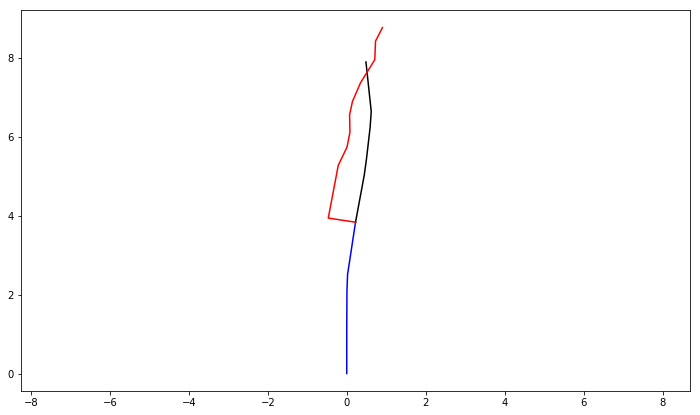

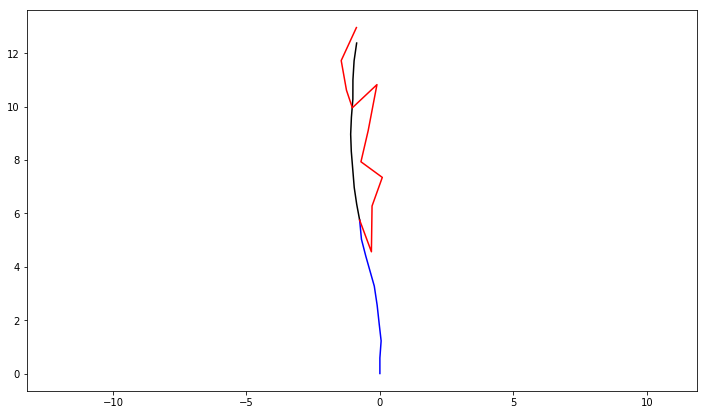

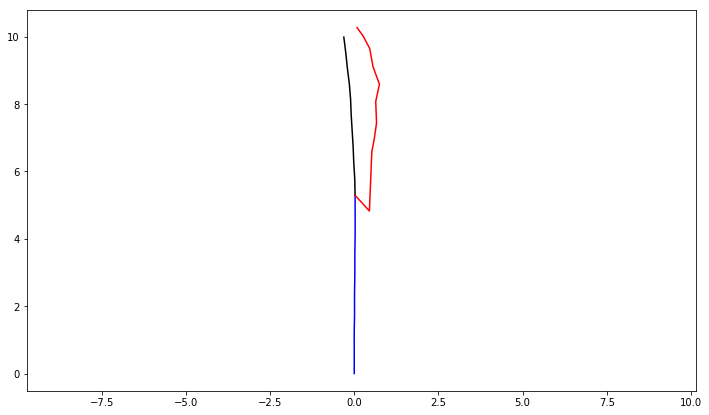

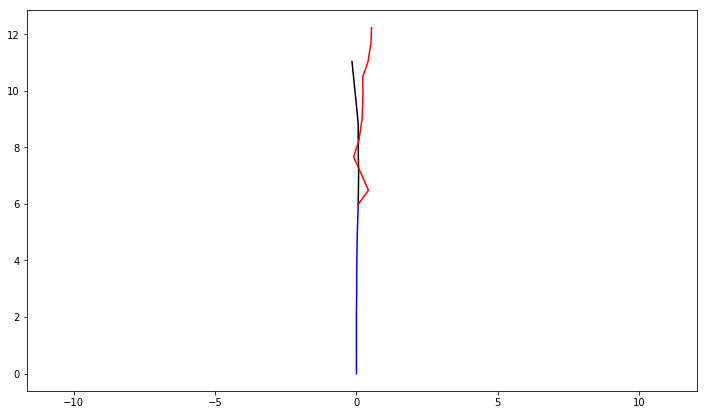

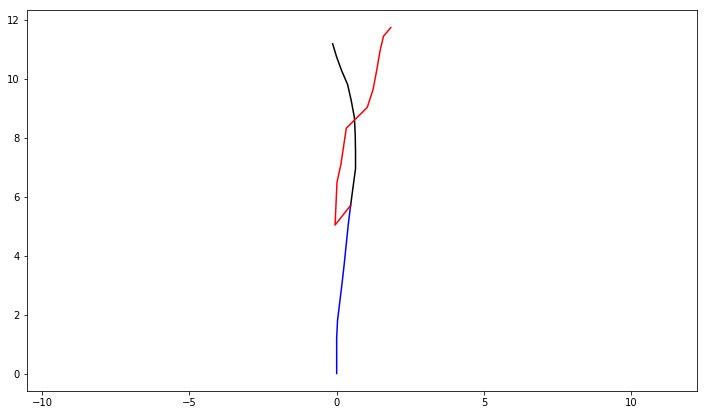

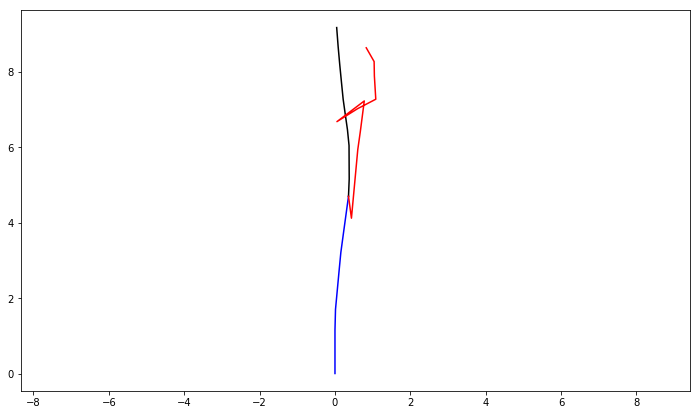

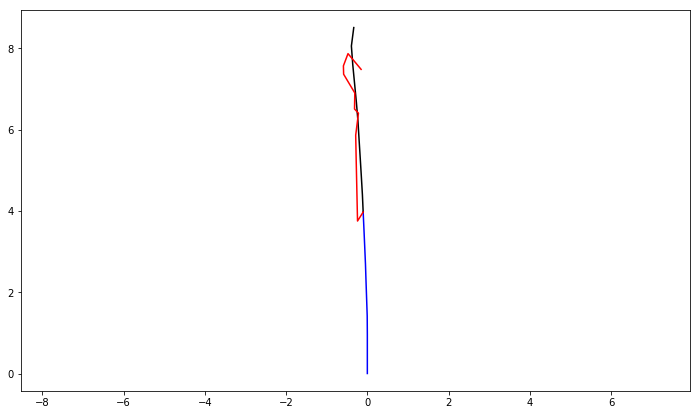

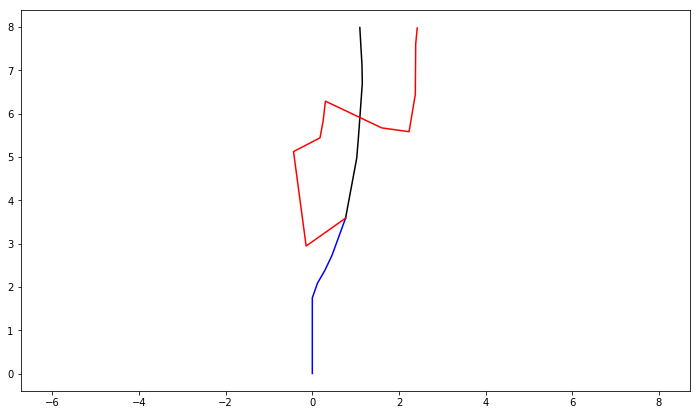

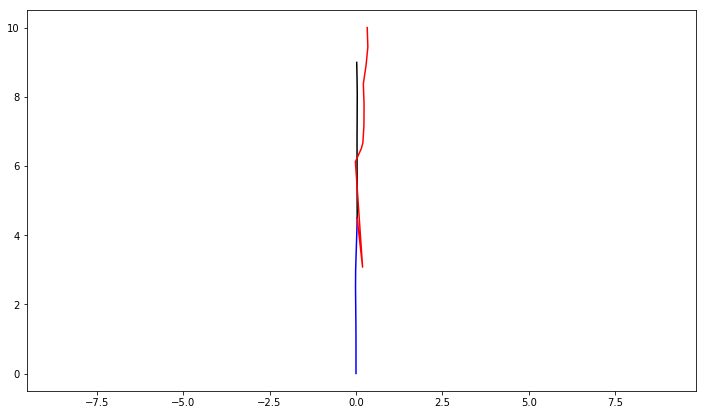

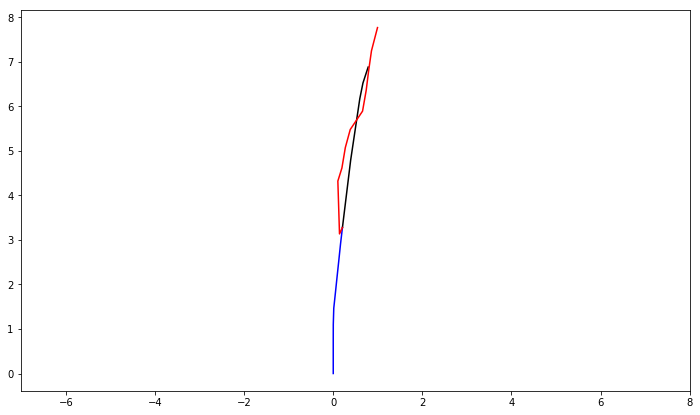

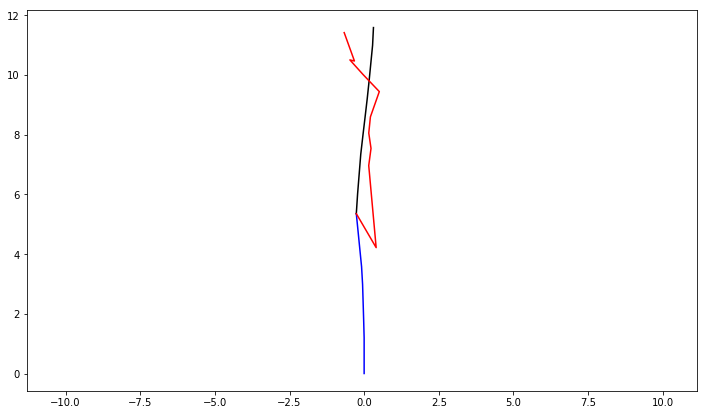

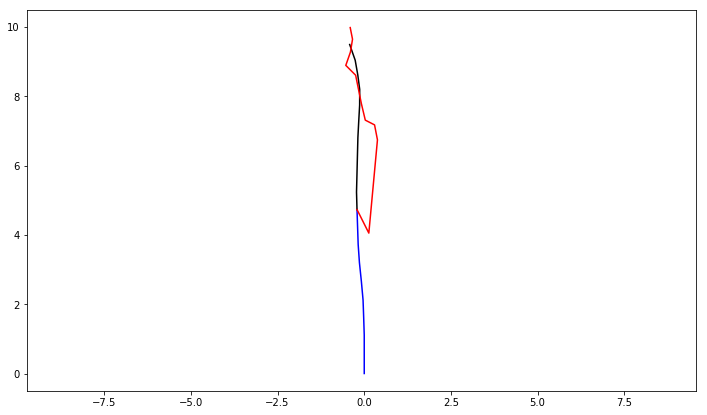

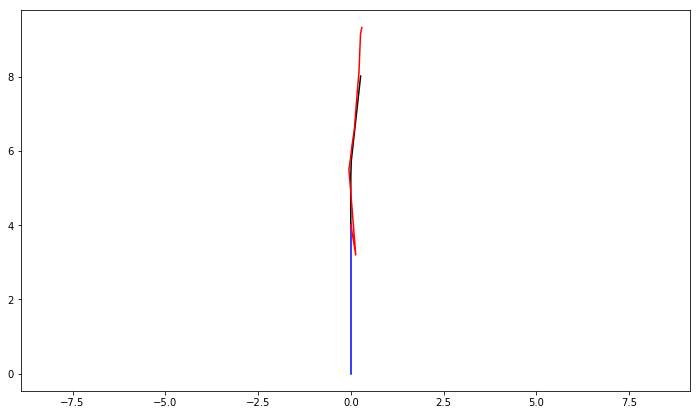

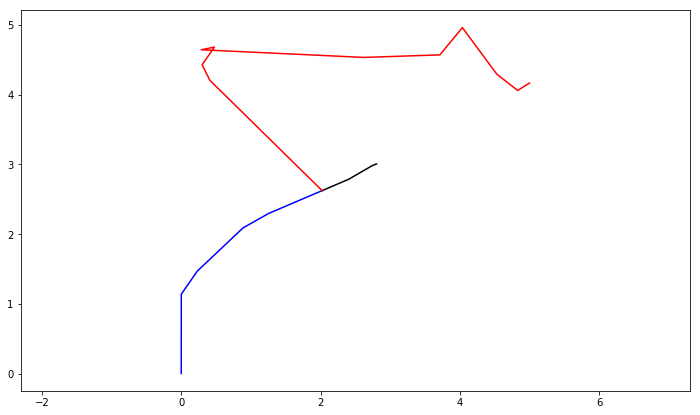

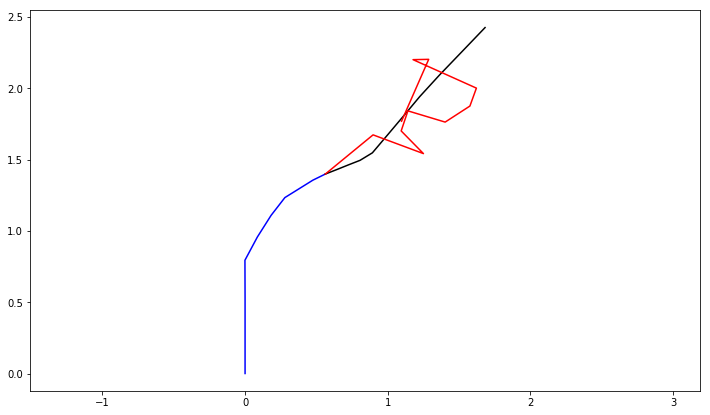

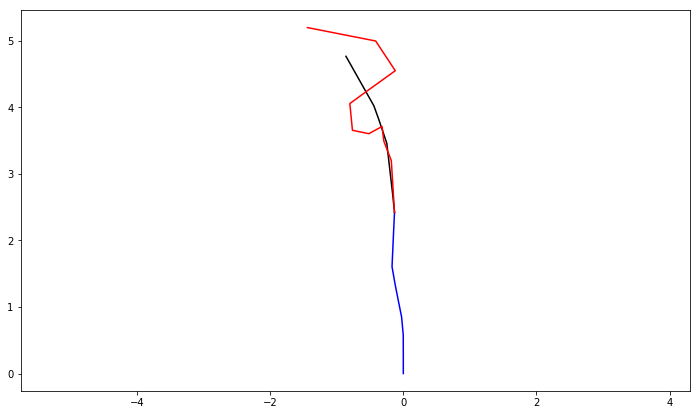

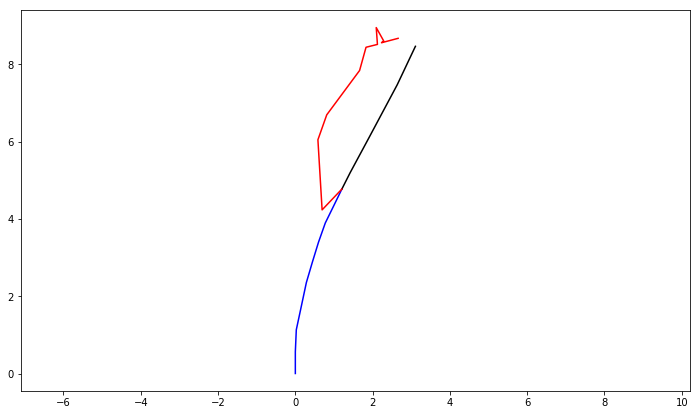

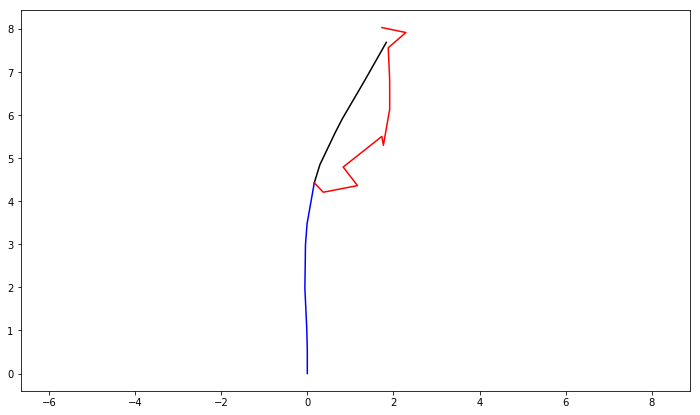

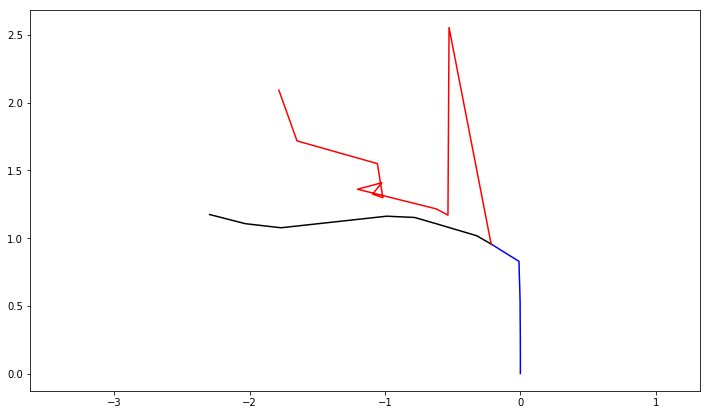

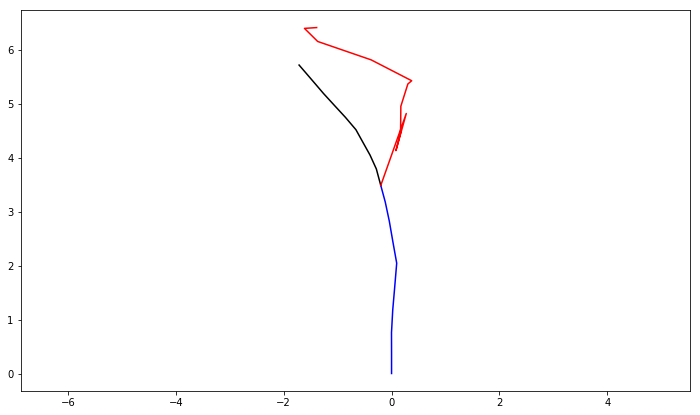

In [17]:
for i in range(20):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[:,(i*20)+3000,0],in_coord[:,i*20+3000,1],c='b')
    plt.plot(gt_coord[:,i*20+3000,0],gt_coord[:,i*20+3000,1],c='k')
    plt.plot(output_coord[:,i*20+3000,0],output_coord[:,i*20+3000,1],c='r')
    plt.axis('equal')

In [21]:
sum(sum(sum(inputs>0)))

tensor(67, dtype=torch.uint8)